In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor

# Guide and Ideas for Capstone Project

We begin this guide by downloading the data:

In [2]:
X = np.load('data/initial_inputs.npy')
Y = np.load('data/initial_outputs.npy')

## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [3]:
next_query = np.random.uniform(size = 2)
print(next_query)

[0.78427581 0.0536481 ]


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

# Upper Confidence Bound

A second alternative would be to use Bayesian Optimization and consider an Upper Confidence Bound acquisition function:

In [6]:
gpr = GaussianProcessRegressor()
gpr.fit(X, Y)

# to optimize the acquisition function, we will simply use gridsearch over a space of 10.000 gridpoints
# the NumPy library's linspace function to generate an array x1 of 100 evenly spaced numbers: start of 0.6; end of 0.65; 100 samples to generate
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)

X_grid = []
for i in range(len(x1)):
    for j in range(len(x2)):
        X_grid.append([x1[i], x2[j]])

X_grid = np.array(X_grid)
mean, std = gpr.predict(X_grid, return_std = True)
ucb = mean + 1.96 * std

idx_max = np.argmax(ucb)
next_query = X_grid[idx_max]
print(next_query)

[0.49494949 0.54545455]


## Visualizing our data and thinking of the problem

It is important when tackling problems to really think about the best strategy and to do some exploratory data analysis. Let's consider what we know about the problem:

1. From the hints, we expect two modes in the unknown function.

2. From the hints, we know that most of our queries should be zero!

3. The problem is two-dimensional.

4. The problem will have small length-scale (that is, we expect the modes to be very small)

From (3.) we can take advantage, and plot the initial data:

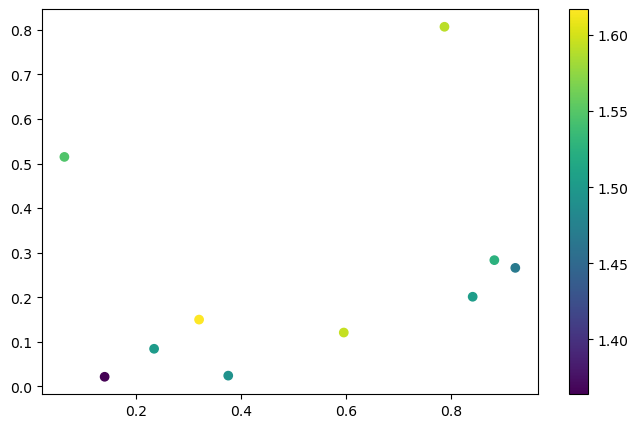

In [7]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.scatter(X[:, 0], X[:, 1], c = Y)
plt.colorbar()

We know that function has two kinds of local maximums, thanks to the hints, we also expect most of our reading to be zero. The fact that we have a perturbation or non-zero value at $x$ = [0.6262626262626263, 0.6767676767676768] means we should be interested in this area. An alternative solution would be to focus only on this area, there are two ways to do this:

1. Run random search in an area restricted around $x$ = [0.6262626262626263, 0.6767676767676768]

2. Solve the UCB in an area restricted around $x$ = [0.6262626262626263, 0.6767676767676768]

Below we provide code for both:

In [8]:
# Random search around an area restricted around $x$ = [0.03, 0.14]
next_query_x1 = np.random.normal(0.03, scale = 0.01)
next_query_x2 = np.random.normal(0.14, scale = 0.01)
print('Next query Random: ', [next_query_x1, next_query_x2])

Next query Random:  [0.03447103022605068, 0.13292490569923957]


In [9]:


# Using a restricted UCB
gpr = GaussianProcessRegressor()
gpr.fit(X, Y)

# to optimize the acquisition function, we will simply use gridsearch over a space of 10.000 gridpoints
x1 = np.linspace(0.01, 0.55, 100)
x2 = np.linspace(0.55, 0.14, 100)

X_grid = []
for i in range(len(x1)):
    for j in range(len(x2)):
        X_grid.append([x1[i], x2[j]])

X_grid = np.array(X_grid)
mean, std = gpr.predict(X_grid, return_std = True)
ucb = mean + 1.96 * std

idx_max = np.argmax(ucb)
next_query = X_grid[idx_max]
print('Next query UCB: ', next_query)

Next query UCB:  [0.49       0.54171717]


Doing this every week, we expect to be able to find the first of the two modes! This should would be enough to provide a good solution to the problem. To really verify if we found the maximum, we would need to find a second mode, however, we may be unlucky and simply never find it. This is an important part of Machine Learning: in theory we might want optimal, perfect solutions, but in practice most of the advancements can be done with simple solutions and careful consideration of the data available to us.

# Looking at the solution:

Below I include the real function that the learners are trying to optimize: note that either of the two strategies shown would have given good results. Overall the capstone is meant to inspire creativity, good data analysis, and use of different models. There is no one correct solution! After all, real life and real data are very messy and it requires all the above skills to apply Machine Learning in the real world.

In [ ]:
def function1(x1, x2):
        '''
        Sum of two EASOM functions: https://www.sfu.ca/~ssurjano/easom.html

        First one is rescaled by two, and optimum is shifted by 1.72 in x1
        Second one is simply shifted so that optimum lies at -pi and pi

        Therefore optimum lies at (pi + 1.72, pi) (after coordinate transformation)
        '''
        x1 = (x1 - 0.5)*40
        x2 = (x2 - 0.5)*40

        ea1 = np.cos(x1 - 2)*np.cos(x2 - 2)*np.exp(-(x1 - np.pi - 2)**2 - (x2 - np.pi -2)**2) * 2
        ea2 = np.cos(-x1) * np.cos(-x2) * np.exp(-(x1 + np.pi)**2 - (x2 + np.pi)**2)
        return ea1 + ea2

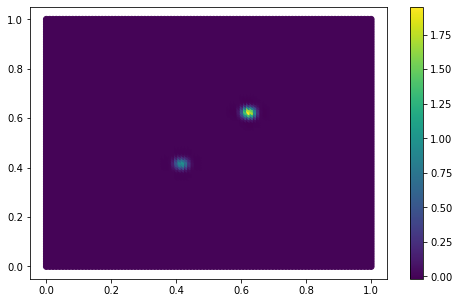

In [ ]:
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)

X_real = []

Y_real = []
for i in range(len(x1)):
    for j in range(len(x2)):
        X_real.append([x1[i], x2[j]])
        Y_real.append(function1(x1[i], x2[j]))

X_real = np.array(X_real)

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.scatter(X_real[:, 0], X_real[:, 1], c = Y_real)
plt.colorbar()